# PRÉDIRE LA DEMANDE EN ÉLECTRICITÉ

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.
La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.)  
Tout le challenge est de mettre en adéquation l'offre et la demande !

## Importation des modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import*
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats
import scipy.stats as st

import pingouin as pg

## Chargement des données

In [2]:
df1 = pd.read_csv('/Users/anissa/conso_energie.csv', encoding='latin-1', sep=';')
df1.head()

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


In [3]:
dju_chauffage = pd.read_csv('/Users/anissa/dju.csv', encoding='latin-1', 
                  sep=';', header=11, decimal=',').rename(columns={"Unnamed: 0": "mois"}).sort_values("mois")
dju_chauffage.head()

,mois,JAN,FÃV,MAR,AVR,MAI,JUN,JUI,AOÃ,SEP,OCT,NOV,DÃC,Total
9,2012,336.0,435.9,201.9,230.3,83.3,35.0,12.4,2.4,58.0,154.6,296.2,345.9,2191.5
8,2013,429.2,402.2,376.6,209.5,158.4,43.6,0.6,5.0,41.5,105.0,303.9,349.5,2424.8
7,2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16.0,92.3,222.6,368.2,1811.5
6,2015,392.0,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195.0,248.1,1986.2
5,2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176.0,285.6,390.8,2207.3


In [4]:
dju_clim = pd.read_csv('/Users/anissa/dju_clim.csv', encoding='latin-1', 
                       sep=';', header=11, decimal=',')\
                        .rename(columns={"Unnamed: 0": "mois"}).sort_values("mois")

dju_clim.head()

,mois,JAN,FÃV,MAR,AVR,MAI,JUN,JUI,AOÃ,SEP,OCT,NOV,DÃC,Total
9,2012,0,0,0.0,0.0,30.1,25.6,60.4,117.9,20.4,1.4,0.0,0,255.6
8,2013,0,0,0.0,3.8,0.0,29.9,152.1,89.2,27.1,4.3,0.0,0,306.2
7,2014,0,0,0.0,0.0,2.2,41.3,101.1,35.7,45.8,7.1,0.0,0,233.0
6,2015,0,0,0.0,2.3,2.8,64.8,139.1,122.4,1.0,0.0,0.3,0,332.6
5,2016,0,0,0.0,0.0,8.5,37.0,105.6,121.4,59.1,0.0,0.0,0,331.5


________________________________

# Exploration des données

### 1. Consommation d'électricité en France

#### 1.1. Travail sur le dataframe

In [5]:
# On sélectionne la zone géographique 
df = df1.loc[df1["Territoire"]=="France"].reset_index(drop=True)\
            .sort_values("Mois")[["Mois", "Consommation totale"]]

df.columns = ["date", "consommation"] # création du df
df["date"] = pd.to_datetime(df["date"]) # conversion en datetime

df.head()

,date,consommation
0,2012-01-01,51086
1,2012-02-01,54476
2,2012-03-01,43156
3,2012-04-01,40176
4,2012-05-01,35257


#### 1.2. Représentation graphique de la consommation en énergie électrique

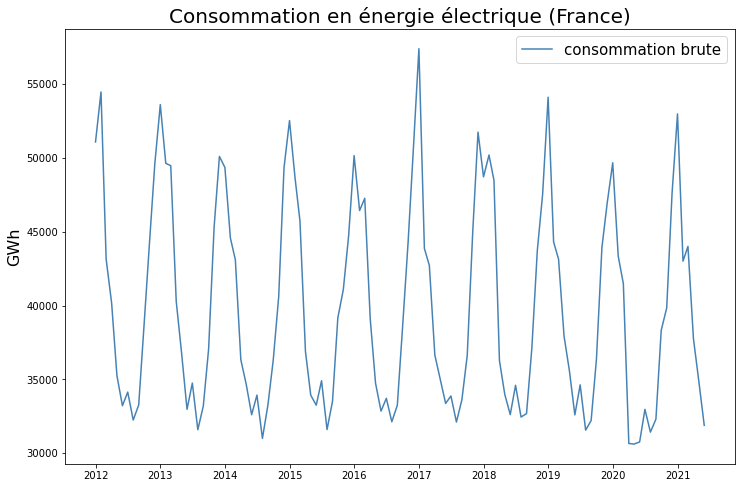

In [6]:
plt.figure(figsize=(12,8))

plt.plot(df["date"], df["consommation"], label="consommation brute", color="steelblue")
plt.title("Consommation en énergie électrique (France)", fontsize=20)
plt.ylabel("GWh", fontsize=16)
plt.legend(fontsize=15)

plt.savefig('/Users/anissa/P9_01_consommation électrique.jpg', dpi=1200)

plt.show()

### 2. DJU chauffage

#### 2.1. Travail sur le dataframe

In [7]:
# On supprime la colonne "total"
dju_chauffage = dju_chauffage.drop('Total', axis=1)

# On renomme les colonnes
dju_chauffage.columns = ['annee', '01', '02', '03', '04', '05', '06', 
               '07', '08', '09', '10', '11', '12']

# On crée un colonne "mois"
dju_chauffage = pd.melt(dju_chauffage, id_vars='annee', var_name='mois', value_name='dju_chauffage')

# On concatène les années et les mois + conversion en datetime
dju_chauffage['date'] = pd.to_datetime(dju_chauffage['annee']\
                                       .astype(str) + '-' + dju_chauffage['mois'], 
                                                                     format='%Y-%m')
dju_chauffage = dju_chauffage.drop(['annee', 'mois'], axis=1)

dju_chauffage.head()

,dju_chauffage,date
0,336.0,2012-01-01
1,429.2,2013-01-01
2,324.4,2014-01-01
3,392.0,2015-01-01
4,364.4,2016-01-01


#### 2.2. Représentation graphique des DJU chauffage à Paris

<Figure size 864x576 with 0 Axes>

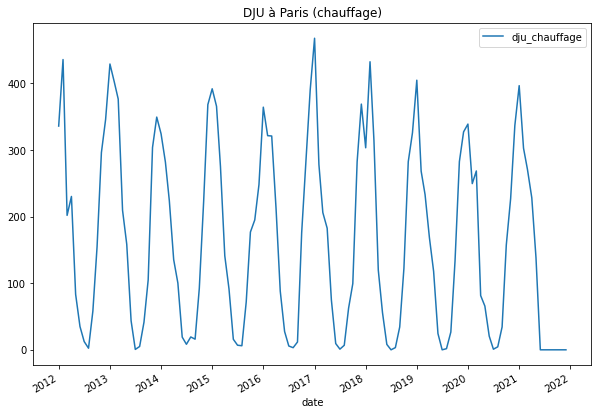

In [8]:
plt.figure(figsize=(12,8))

dju_chauffage.plot(x='date', figsize=(10,7))

plt.title('DJU à Paris (chauffage)')

plt.savefig('/Users/anissa/P9_02_dju chauffage.jpg', dpi=1200)

### 3. DJU Climatisation

#### 3.1. Travail sur le dataframe

In [9]:
# On supprime la colonne "total"
dju_clim = dju_clim.drop('Total', axis=1)

# On renomme les colonnes
dju_clim.columns = ['annee', '01', '02', '03', '04', '05', '06', 
                    '07', '08', '09', '10', '11', '12']

# On crée une colonne "mois"
dju_clim = pd.melt(dju_clim, id_vars='annee', var_name='mois', value_name='dju_clim')

# On concatène les années et les mois + conversion en datetime
dju_clim['date'] = pd.to_datetime(dju_clim['annee'].astype(str) + '-' + dju_clim['mois'],
                                                                          format='%Y-%m')
dju_clim = dju_clim.drop(['annee', 'mois'], axis=1)

dju_clim.head()

,dju_clim,date
0,0.0,2012-01-01
1,0.0,2013-01-01
2,0.0,2014-01-01
3,0.0,2015-01-01
4,0.0,2016-01-01


#### 3.2. Représentation graphique des DJU climatisation à Paris

<Figure size 864x576 with 0 Axes>

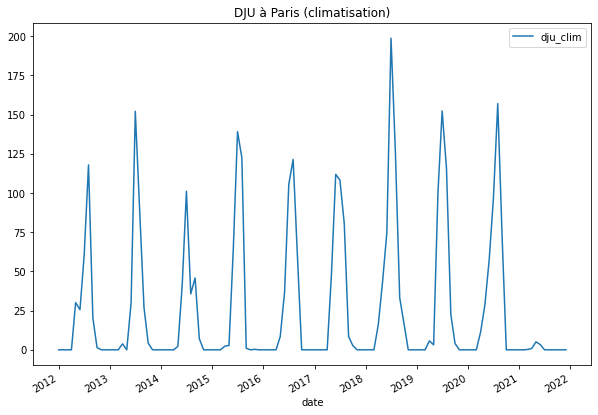

In [10]:
plt.figure(figsize=(12,8))

dju_clim.plot(x='date', figsize=(10,7))

plt.title('DJU à Paris (climatisation)')
plt.legend()

plt.savefig('/Users/anissa/P9_03_dju clim.jpg', dpi=1200)

### 4. Création d'un dataframe unique

#### 4.1. Ajout des variables : _DJU chauffage et consommation électrique_

In [11]:
# Merge entre les 2 df
data = pd.merge(dju_chauffage, df, how='inner')

data = data.set_index('date').sort_index() # date en index

data.head()

,dju_chauffage,consommation
date,,
2012-01-01,336.0,51086
2012-02-01,435.9,54476
2012-03-01,201.9,43156
2012-04-01,230.3,40176
2012-05-01,83.3,35257


##### 4.1.1. Représentation graphique

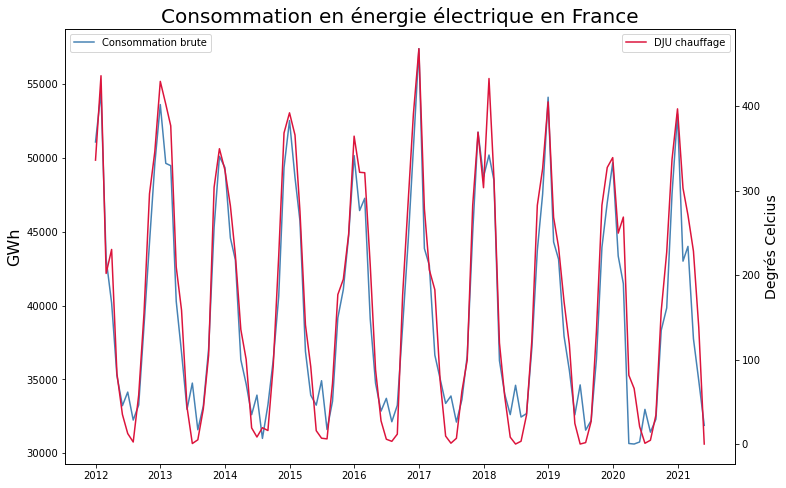

In [12]:
plt.figure(figsize=(12,8))
plt.plot(data["consommation"], label="Consommation brute", color="steelblue")
plt.ylabel("GWh", fontsize=16), plt.legend(loc="upper left")

ax2 = plt.gca().twinx() ; plt.plot(data["dju_chauffage"], label="DJU chauffage", color="crimson")
plt.title("Consommation en énergie électrique en France", fontsize=20), plt.ylabel("Degrés Celcius", fontsize=14), plt.legend()

plt.savefig('/Users/anissa/P9_04_consommation électrique et dju chauffage.jpg', dpi=1200)

plt.show()

#### 4.2. Ajout de la variable : _DJU climatisation_

In [13]:
# On merge avec notre précédent df
dju_ch = pd.merge(dju_chauffage, dju_clim, how='inner')
data = pd.merge(dju_ch, df, how='inner')

data = data.set_index('date').sort_index() # date en index

data.head() # création du df unique

,dju_chauffage,dju_clim,consommation
date,,,
2012-01-01,336.0,0.0,51086
2012-02-01,435.9,0.0,54476
2012-03-01,201.9,0.0,43156
2012-04-01,230.3,0.0,40176
2012-05-01,83.3,30.1,35257


##### 4.2.1. Représentation graphique

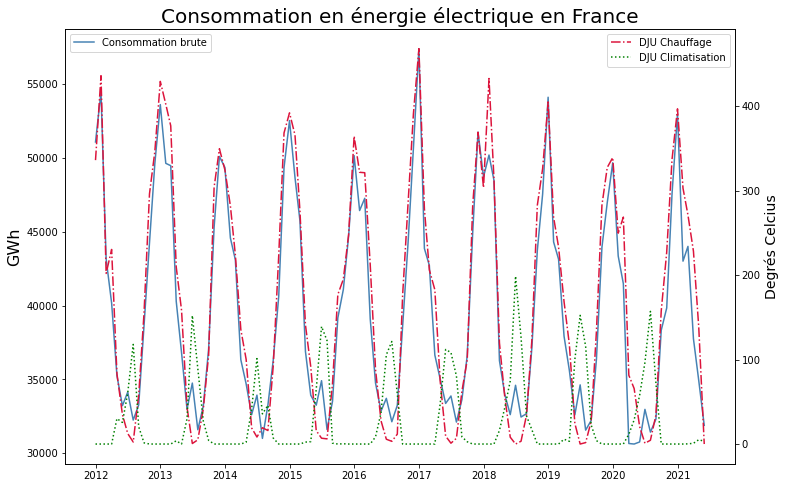

In [14]:
plt.figure(figsize=(12,8))
plt.plot(data["consommation"], label="Consommation brute", color="steelblue")
plt.ylabel("GWh", fontsize=16), plt.legend(loc="upper left")

ax2 = plt.gca().twinx() ; plt.plot(data["dju_chauffage"], label="DJU Chauffage", color="crimson", linestyle='dashdot')

plt.plot(data["dju_clim"], label="DJU Climatisation", color="green", linestyle='dotted')
plt.title("Consommation en énergie électrique en France", fontsize=20), plt.ylabel("Degrés Celcius", fontsize=14), plt.legend()

plt.savefig('/Users/anissa/P9_05_consommation électrique et dju.jpg', dpi=1200)

plt.show()

### 5. Analyse des 3 variables : _Consommation électrique, DJU chauffage et DJU climatisation_

#### 5.1. Répartition des données et tests de normalité

##### 5.1.1. Répartition des données : _consommation électrique_

<Figure size 1440x1440 with 0 Axes>

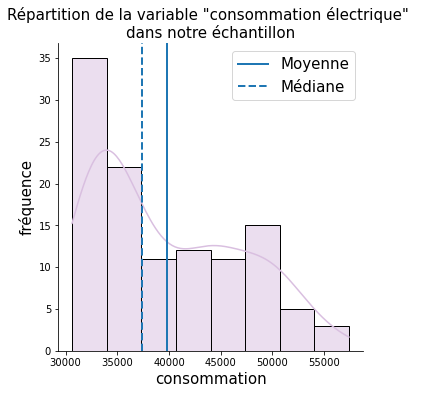

In [15]:
plt.figure(figsize = (20,20))

sns.displot(data["consommation"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=data["consommation"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=data["consommation"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('consommation', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable "consommation électrique" \ndans notre échantillon', size=15)
plt.legend(prop={'size':15})

plt.savefig('/Users/anissa/P9_06_répartition consommation.jpg', dpi=1200)

plt.show()

##### 5.1.2. Test de normalité : _consommation électrique_

In [16]:
# Test de normalité (Kolmogorov-Smirnov)
stats.kstest(data['consommation'], 'norm') # ne suit pas une loi normale

KstestResult(statistic=1.0, pvalue=0.0)

##### 5.1.3. Répartition des données : _DJU chauffage_

<Figure size 3600x3600 with 0 Axes>

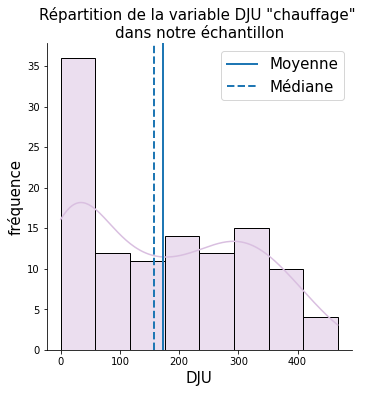

In [17]:
plt.figure(figsize = (50,50))

sns.displot(data["dju_chauffage"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=data["dju_chauffage"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=data["dju_chauffage"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('DJU', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable DJU "chauffage" \ndans notre échantillon', size=15)
plt.legend(prop={'size':15})

plt.savefig('/Users/anissa/P9_07_répartition dju chauffage.jpg', dpi=1200)

plt.show()

##### 5.1.4. Test de normalité : _DJU chauffage_

In [18]:
# Test de normalité (Kolmogorov-Smirnov)
stats.kstest(data['dju_chauffage'], 'norm') # ne suit pas une loi normale

KstestResult(statistic=0.930398955303474, pvalue=2.2876443636143396e-132)

##### 5.1.5. Répartition des données : _DJU climatisation_

<Figure size 1440x1440 with 0 Axes>

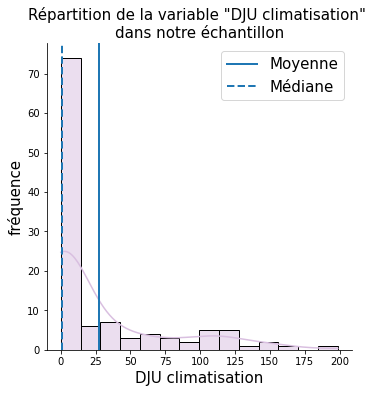

In [19]:
plt.figure(figsize = (20,20))

sns.displot(data["dju_clim"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=data["dju_clim"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=data["dju_clim"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('DJU climatisation', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable "DJU climatisation" \ndans notre échantillon', size=15)
plt.legend(prop={'size':15})

plt.savefig('/Users/anissa/P9_08_répartition dju clim.jpg', dpi=1200)

plt.show()

###### 5.1.6. Test de normalité : _DJU climatisation_

In [20]:
# Test de normalité (Kolmogorov-Smirnov)
stats.kstest(data['dju_clim'], 'norm') # ne suit pas une loi normale

KstestResult(statistic=0.5, pvalue=7.038162000423776e-27)

#### 5.2. Régression linéaire

###### 5.2.1. Travail sur les variables _DJU chauffage_ et _DJU climatisation_

In [21]:
# On crée une colonne unique DJU
data['dju'] = data['dju_chauffage'] + data['dju_clim']
data.head()

,dju_chauffage,dju_clim,consommation,dju
date,,,,
2012-01-01,336.0,0.0,51086,336.0
2012-02-01,435.9,0.0,54476,435.9
2012-03-01,201.9,0.0,43156,201.9
2012-04-01,230.3,0.0,40176,230.3
2012-05-01,83.3,30.1,35257,113.4


##### 5.2.2. Représentation graphique

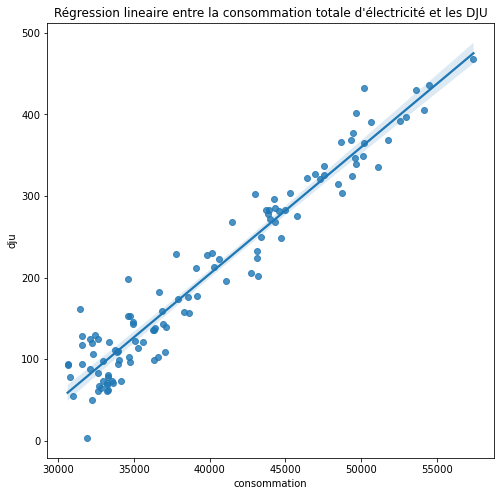

In [22]:
plt.figure(figsize=(8,8))

sns.regplot(x='consommation', y='dju', data=data)
plt.title('Régression lineaire entre la consommation totale d\'électricité et les DJU')

plt.savefig('/Users/anissa/P9_09_régression linéaire.jpg', dpi=1200)

plt.show()

In [23]:
pearson = st.pearsonr(data["dju"], data["consommation"])[0]
p_value = st.pearsonr(data["dju"], data["consommation"])[1]
print("Coefficient de corrélation de Pearson :", pearson)
print("p-value :", p_value)

Coefficient de corrélation de Pearson : 0.9658940238750844
p-value : 1.475814039750126e-67


>> Les points suivent  la droite de régression et couvrent bien l’étendue entière des valeurs. On constate donc une **relation forte** entre nos deux variables, ce qui est confirmé par le coefficient de Pearson proche de 1.


____________________

## Correction de l'effet température

### 1. Régression linéaire de la consommation brute d'électricité selon les DJU

In [24]:
RL = statsmodels.formula.api.ols("consommation ~ dju_chauffage",data=data).fit()
RL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consommation   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1766.
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           2.10e-70
Time:                        16:48:06   Log-Likelihood:                -1011.2
No. Observations:                 114   AIC:                             2026.
Df Residuals:                     112   BIC:                             2032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.131e+04    259.302    120.735      0.000    3.08e+04    3.18e+04
dju_chauffage    48.9023      1.164     42.021      0.000      46.596      51.208
==============================================================================
Omnibus:                        0.899   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.701
Skew:                          -0.192   Prob(JB):                        0.704
Kurtosis:                       3.024   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>> Nos résidus suivent bien une loi normale (Jarque-Bera).

In [25]:
print("COEFFICIENT DE DÉTERMINATION DE RL", round(RL.rsquared, 4))

COEFFICIENT DE DÉTERMINATION DE RL 0.9404


In [26]:
print("Ce modèle explique environ", round(100*RL.rsquared, 2), '% de la variance de la variable "consommation"')

Ce modèle explique environ 94.04 % de la variance de la variable "consommation"


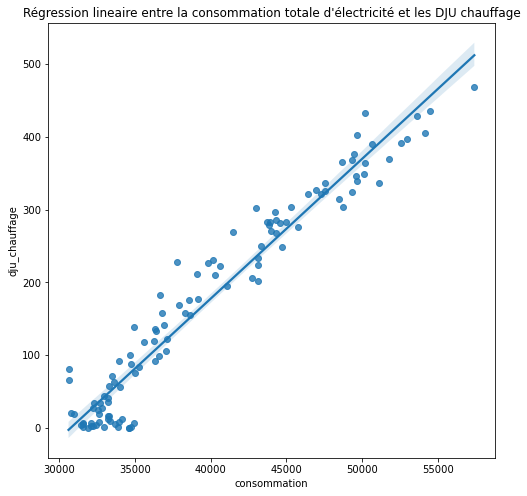

In [27]:
plt.figure(figsize=(8,8))

sns.regplot(x='consommation', y='dju_chauffage', data=data)
plt.title('Régression lineaire entre la consommation totale d\'électricité et les DJU chauffage')

plt.savefig('/Users/anissa/P9_10_régression liénaire consommation et dju chauffage.jpg', dpi=1200)

plt.show()

#### 1.1. Vérification de la fiabilité du modèle : analyse des résidus

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


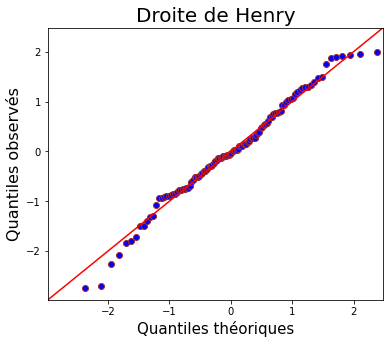

In [28]:
def residus_henry(MODEL, nom, couleur, ax):
    sm.qqplot(MODEL.resid, ax=ax, line="45", fit=True, color=couleur)
    ax.set_title("Droite de Henry", fontsize=20)
    ax.set_xlabel("Quantiles théoriques" ,fontsize=15), ax.set_ylabel("Quantiles observés", fontsize=16)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(RL, "RL", "brown", ax) ; 

plt.show() # suit une loi normale

In [29]:
# Homoscedasticité (homogéinéité des variances des résidus)
pg.homoscedasticity(data, method="bartlett", alpha=.05) # variances homogènes

,T,pval,equal_var
bartlett,18.554223,1.0,True


>> Les conditions de validité du modèle sont **validées**, il est donc _fiable_.

### 2. Correction de l'effet température grâce à une régression linéaire (chauffage)

In [30]:
# On corrige grâce à notre modèle
data["conso_corr"]= RL.predict(data["dju_chauffage"])
data.head()

,dju_chauffage,dju_clim,consommation,dju,conso_corr
date,,,,,
2012-01-01,336.0,0.0,51086,336.0,47738.084135
2012-02-01,435.9,0.0,54476,435.9,52623.419282
2012-03-01,201.9,0.0,43156,201.9,41180.291912
2012-04-01,230.3,0.0,40176,230.3,42569.115918
2012-05-01,83.3,30.1,35257,113.4,35380.484621


#### 2.1. Représentation graphique de la correction

Text(0.5, 1.0, 'Consommation en énergie électrique corrigée')

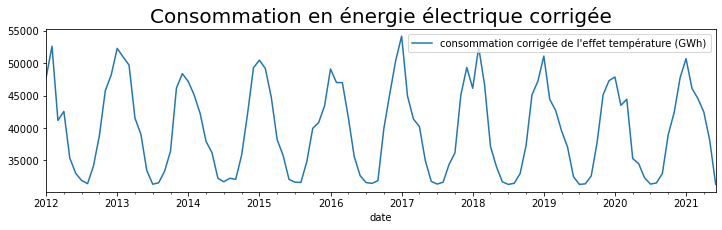

In [31]:
data.plot(y='conso_corr', label="consommation corrigée de l'effet température (GWh)", 
                                                                      figsize=(12,3))
plt.title("Consommation en énergie électrique corrigée", fontsize=20)

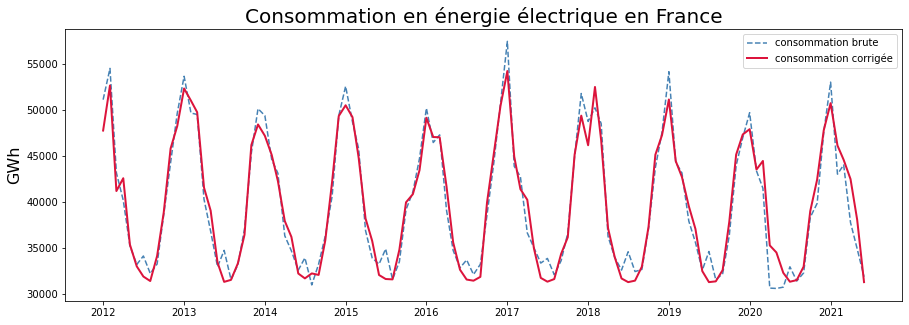

In [32]:
plt.figure(figsize=(15,5))

# Superposition de la consommation brute et de la consommation corrigée
plt.plot(data["consommation"], color="steelblue", linestyle="dashed", label="consommation brute", linewidth=1.5)
plt.plot(data["conso_corr"], color="crimson", label="consommation corrigée", linewidth=2)

plt.title("Consommation en énergie électrique en France", fontsize=20), plt.ylabel("GWh", fontsize=16), plt.legend()

plt.savefig('/Users/anissa/P9_11_consommation électrique corrigée.jpg', dpi=1200)

plt.show()

___________

## Désaisonnalisation de la consommation

Avant d'appliquer un modèle statistique sur une série temporelle, nous devons nous assurer qu'elle est stationnaire (bruit blanc). Une série temporelle est caractérisée par le fait qu'elle évolue avec le temps. Afin de la modéliser, la série doit être dépourvue de ces changements.  
Il existe plusieurs transformations que nous pouvons appliquer à une série afin de la rendre stationnaire, nous les comparerons ici.

In [33]:
# Série non différenciée
y = data['conso_corr']

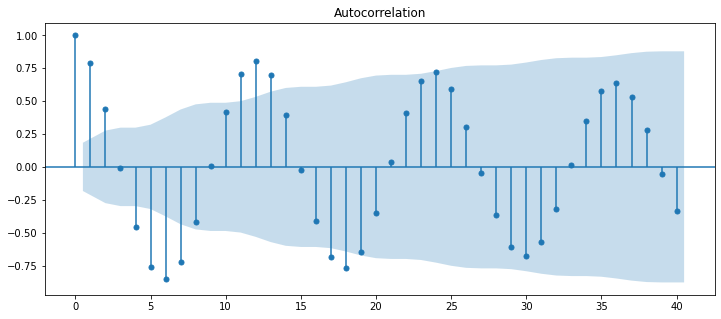

In [34]:
# Autocorrélation (40 lags)
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(y, lags=40, ax=ax)
plt.show()

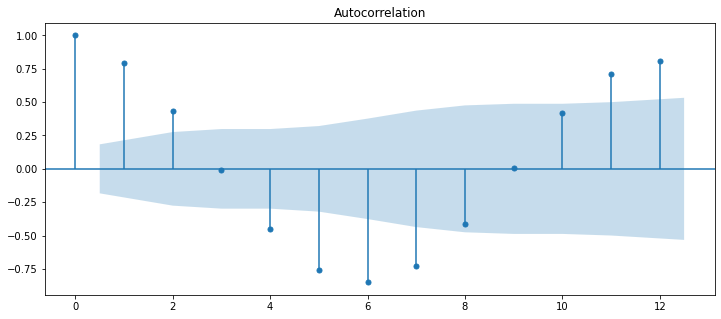

In [35]:
# Autocorrélation (12 lags)
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(y, lags=12, ax=ax)
plt.show()

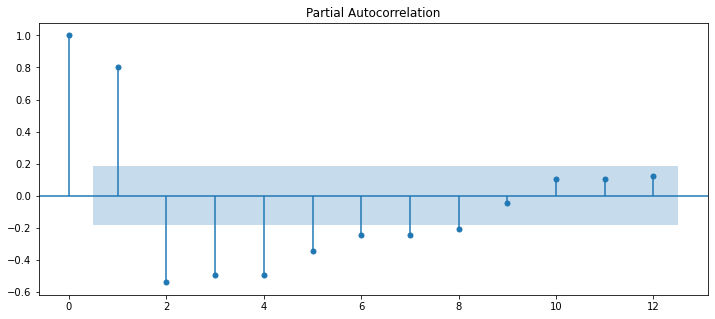

In [36]:
# Autocorrélation partielle (12 lags)
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(y, lags=12, ax=ax)
plt.show()

>> On observe que notre modèle n'est **pas stationnaire**. Des pics significatifs réguliers sont présents.

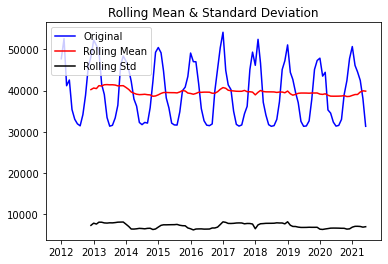

Results of Dickey-Fuller Test:
Test Statistic                  -2.147588
p-value                          0.225815
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [37]:
# Test de stationnarité
def test_stationarity(timeseries):
#Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(y)

### 1. Désaisonnalisation grâce aux moyennes mobiles

#### 1.1. Méthode 1 - Décomposition saisonnière (statsmodels)

Text(0.5, 0.98, 'Décomposition saisonnière de la consommation corrigée')

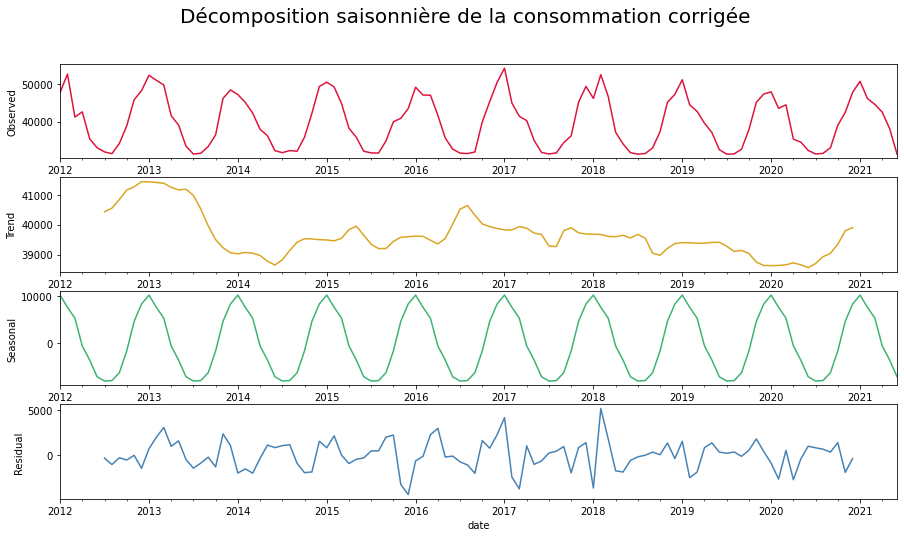

In [38]:
ds = seasonal_decompose(data['conso_corr'],  model="additive") # Décomposition saisonnière

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))

ds.observed.plot(ax=ax1, color="crimson") # Valeurs observées
ds.trend.plot(ax=ax2, color="goldenrod") # Tendance
ds.seasonal.plot(ax=ax3, color="mediumseagreen") # Saisonnalité
ds.resid.plot(ax=ax4, color="steelblue") # Résidus

ax1.set_ylabel("Observed") ; ax2.set_ylabel("Trend") ; ax3.set_ylabel("Seasonal") ; ax4.set_ylabel("Residual")
plt.suptitle("Décomposition saisonnière de la consommation corrigée", fontsize=20)

##### 1.1.1. Désaisonnalisation : consommation corrigée de l'effet de température et de l'effet saisonnier

In [39]:
# On récupère la saisonnalité
data['saisonnalite'] = ds.seasonal 

# On la soustrait à notre consommation corrigée
data['Consommation désaisonnalisée'] = data['conso_corr'] - data['saisonnalite']

data.head()

,dju_chauffage,dju_clim,consommation,dju,conso_corr,saisonnalite,Consommation désaisonnalisée
date,,,,,,,
2012-01-01,336.0,0.0,51086,336.0,47738.084135,10177.087499,37560.996636
2012-02-01,435.9,0.0,54476,435.9,52623.419282,7582.160721,45041.258560
2012-03-01,201.9,0.0,43156,201.9,41180.291912,5258.081114,35922.210798
2012-04-01,230.3,0.0,40176,230.3,42569.115918,-658.684067,43227.799985
2012-05-01,83.3,30.1,35257,113.4,35380.484621,-3684.179907,39064.664528


##### 1.1.2. Test de la stationnarité : Dickey-Fuller

In [40]:
result = adfuller(data["Consommation désaisonnalisée"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') # stationnaire

ADF Statistic: -2.8468357122617847
p-value: 0.05188877855771086
Critial Values:
   1%, -3.497501033
Critial Values:
   5%, -2.89090644
Critial Values:
   10%, -2.5824349


##### 1.1.3. Autocorrélation et autocorrélation partielle

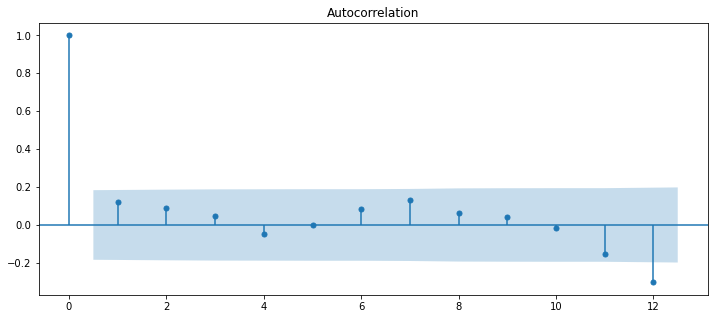

In [41]:
# Autocorrélation
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(data['Consommation désaisonnalisée'], lags=12, ax=ax)
plt.show()

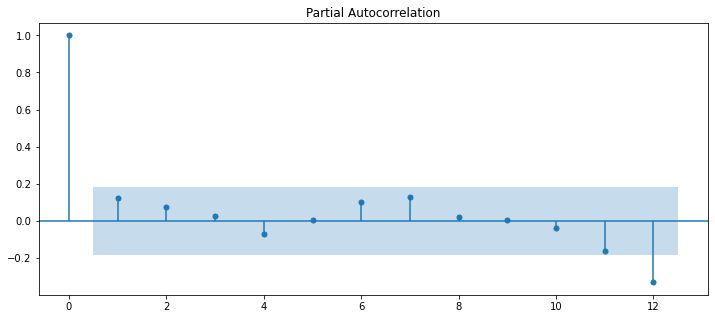

In [42]:
# Autocorrélation partielle
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(data['Consommation désaisonnalisée'], lags=12, ax=ax)
plt.show()

>> On ne constate _plus de pics à intervalle régulier_, ce qui montre bien que notre série est **stationnaire**.

##### 1.1.4. Test de stationnarité : résidus

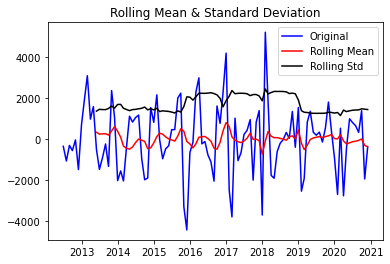

Results of Dickey-Fuller Test:
Test Statistic                -6.397172e+00
p-value                        2.037264e-08
#Lags Used                     1.100000e+01
Number of Observations Used    9.000000e+01
Critical Value (1%)           -3.505190e+00
Critical Value (5%)           -2.894232e+00
Critical Value (10%)          -2.584210e+00
dtype: float64


In [43]:
residual = ds.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose) # stationnaire

#### 1.2. Méthode 2 - soustraction des moyennes mobiles

In [44]:
# Calcul des moyennes mobiles sur notre consommation corrigée
data['MM'] = data['conso_corr'].rolling(window=12).mean() # 12 mois

data.head()

,dju_chauffage,dju_clim,consommation,dju,conso_corr,saisonnalite,Consommation désaisonnalisée,MM
date,,,,,,,,
2012-01-01,336.0,0.0,51086,336.0,47738.084135,10177.087499,37560.996636,NaN
2012-02-01,435.9,0.0,54476,435.9,52623.419282,7582.160721,45041.258560,NaN
2012-03-01,201.9,0.0,43156,201.9,41180.291912,5258.081114,35922.210798,NaN
2012-04-01,230.3,0.0,40176,230.3,42569.115918,-658.684067,43227.799985,NaN
2012-05-01,83.3,30.1,35257,113.4,35380.484621,-3684.179907,39064.664528,NaN


##### 1.2.1. Représentation graphique

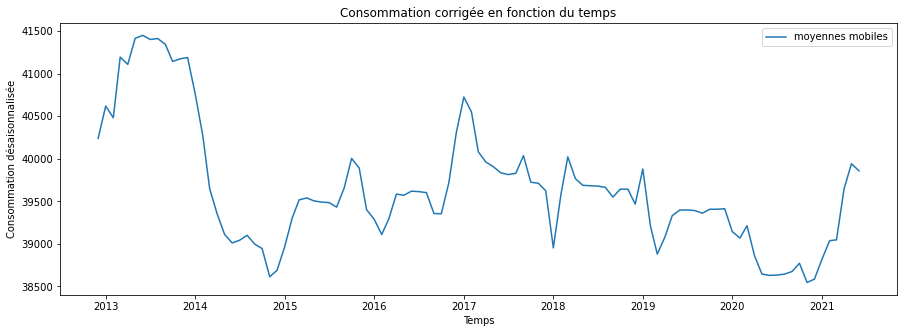

In [45]:
plt.figure(figsize=(15,5))

plt.plot(data['MM'], label='moyennes mobiles')

plt.xlabel('Temps')
plt.ylabel('Consommation désaisonnalisée')
plt.title('Consommation corrigée en fonction du temps')
plt.legend()

plt.show()

##### 1.2.2. Différenciation : nettoyer la série de sa saisonnalité

In [46]:
# On soustrait les moyennes mobiles de notre consommation corrigée
data["diff"] = data['conso_corr'] - data['MM']

data.head()

,dju_chauffage,dju_clim,consommation,dju,conso_corr,saisonnalite,Consommation désaisonnalisée,MM,diff
date,,,,,,,,,
2012-01-01,336.0,0.0,51086,336.0,47738.084135,10177.087499,37560.996636,NaN,NaN
2012-02-01,435.9,0.0,54476,435.9,52623.419282,7582.160721,45041.258560,NaN,NaN
2012-03-01,201.9,0.0,43156,201.9,41180.291912,5258.081114,35922.210798,NaN,NaN
2012-04-01,230.3,0.0,40176,230.3,42569.115918,-658.684067,43227.799985,NaN,NaN
2012-05-01,83.3,30.1,35257,113.4,35380.484621,-3684.179907,39064.664528,NaN,NaN


##### 1.2.3. Test de stationnarité : Dickey-Fuller

In [47]:
result = adfuller(data["diff"].dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') # stationnaire

ADF Statistic: -7.808870583541387
p-value: 7.1585491393396924e-12
Critial Values:
   1%, -3.5011373281819504
Critial Values:
   5%, -2.8924800524857854
Critial Values:
   10%, -2.5832749307479226


#### 1.3. Méthode 3 - Décroissance exponentielle

In [48]:
# On soustrait les moyennes mobiles exponentielles de la consommation corrigée
data['diff_ema'] = data['conso_corr'] - data['conso_corr'].ewm(span=12).mean() # 12 mois

data.head()

,dju_chauffage,dju_clim,consommation,dju,conso_corr,saisonnalite,Consommation désaisonnalisée,MM,diff,diff_ema
date,,,,,,,,,,
2012-01-01,336.0,0.0,51086,336.0,47738.084135,10177.087499,37560.996636,NaN,NaN,0.000000
2012-02-01,435.9,0.0,54476,435.9,52623.419282,7582.160721,45041.258560,NaN,NaN,2239.111942
2012-03-01,201.9,0.0,43156,201.9,41180.291912,5258.081114,35922.210798,NaN,NaN,-5611.686080
2012-04-01,230.3,0.0,40176,230.3,42569.115918,-658.684067,43227.799985,NaN,NaN,-2889.869549
2012-05-01,83.3,30.1,35257,113.4,35380.484621,-3684.179907,39064.664528,NaN,NaN,-7340.208186


##### 1.3.1. Représentation graphique

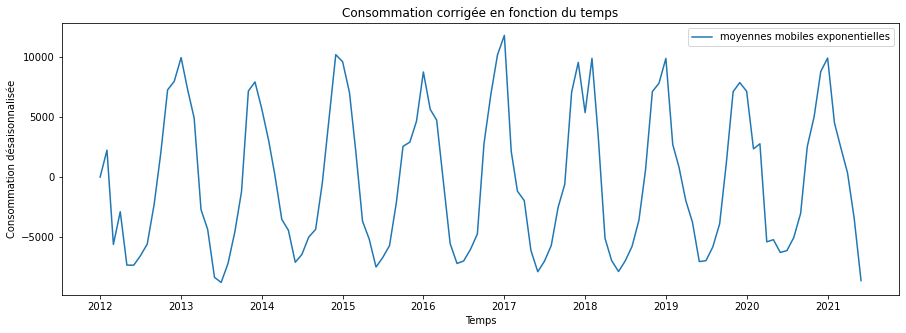

In [49]:
plt.figure(figsize=(15,5))

plt.plot(data['diff_ema'], label='moyennes mobiles exponentielles')

plt.xlabel('Temps')
plt.ylabel('Consommation désaisonnalisée')
plt.title('Consommation corrigée en fonction du temps')
plt.legend()

plt.show()

##### 1.3.2. Test de stationnarité : Dickey-Fuller

In [50]:
result = adfuller(data["diff_ema"], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') # stationnaire

ADF Statistic: -7.618862984154269
p-value: 2.1551054428282957e-11
Critial Values:
   1%, -3.4942202045135513
Critial Values:
   5%, -2.889485291005291
Critial Values:
   10%, -2.5816762131519275


#### 1.4. Méthode 4 - Décalage temporel

En appliquant le décalage temporel, nous soustrayons chaque point par celui qui l’a précédé.

In [51]:
def differenciation(serie, n):
    diff=serie - serie.shift(n)
    return(diff.dropna())

def test_dickey_fuller(serie):
    AF=adfuller(serie)
    print("Pvalue du test de Dickey-Fuller:", AF[1])
    print("Statistique de test:", AF[0])
    print("Valeurs Critiques:")
    for key, value in AF[4].items():
        print('\t%s: %.3f' % (key, value))

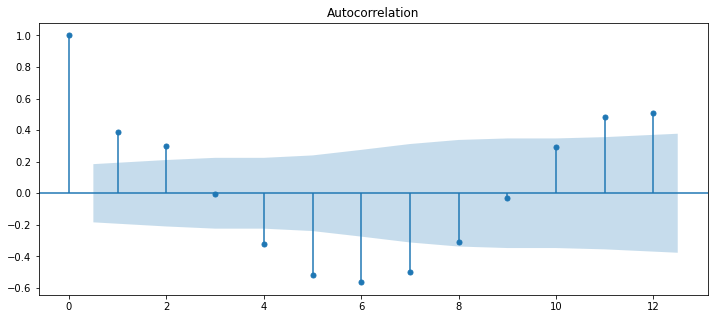

Pvalue du test de Dickey-Fuller: 1.247539862132556e-13
Statistique de test: -8.499754616849321
Valeurs Critiques:
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [52]:
# Création des données de consommation corrigées différenciées de 1
diff_1=differenciation(data["conso_corr"], 1)

# Affichage de l'autocorrélogramme
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(diff_1, lags=12, ax=ax)

plt.show()

# Test de Dickey-Fuller
test_dickey_fuller(diff_1)

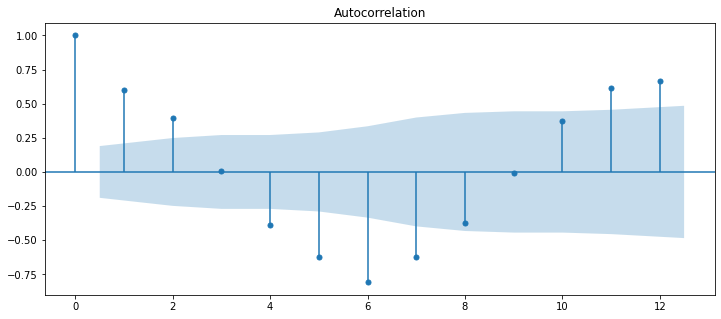

Pvalue du test de Dickey-Fuller: 4.804654553236017e-10
Statistique de test: -7.075841015068167
Valeurs Critiques:
	1%: -3.502
	5%: -2.893
	10%: -2.583


In [53]:
# Création des données de consommation corrigées différenciées de 6
diff_6=differenciation(diff_1, 6)

# Affichage de l'autocorrélogramme
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(diff_6, lags=12, ax=ax)

plt.show()

# Test de Dickey-Fuller
test_dickey_fuller(diff_6)

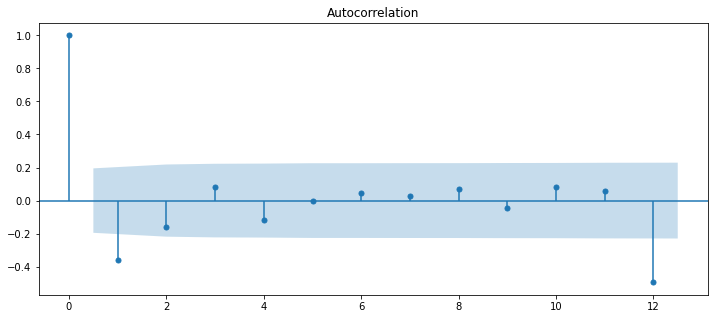

Pvalue du test de Dickey-Fuller: 5.192108824766355e-07
Statistique de test: -5.778482475877935
Valeurs Critiques:
	1%: -3.508
	5%: -2.895
	10%: -2.585


In [54]:
# Création des données de consommation corrigées différenciées de 12
diff_12=differenciation(diff_1, 12)

# Affichage de l'autocorrélogramme
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(diff_12, lags=12, ax=ax)

plt.show()

# Test de Dickey-Fuller
test_dickey_fuller(diff_12)

>> La différenciation de 12 a permis de **stationnariser la série**. Les pics sont beaucoup moins réguliers que sur les autres autocorrélogrammes.

### 2. Comparaison entre les 4 méthodes

#### 2.1. Représentation graphique

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data['diff_ema'], label='différenciation avec moyennes mobiles exponentielles')
plt.plot(data['diff'], label='différenciation avec moyennes mobiles')
plt.plot(diff_12, label='différenciation décalage temporel')
plt.plot(data['conso_corr'], label='consommation corrigée')
plt.plot(data['Consommation désaisonnalisée'], label='consommation désaisonnalisée (lissage)')
plt.xlabel('Temps')
plt.ylabel('Consommation désaisonnalisée')
plt.title('Consommation corrigée en fonction du temps')
plt.legend()

plt.savefig('/Users/anissa/P9_12_consommation corrigée.jpg', dpi=1200)

plt.show()

#### 2.2. Conclusion

>> On constate que la différenciation avec la **soustraction des moyennes mobiles**, la **décroissance exponentielle** et le **décalage temporel** nous renvoient des séries temporelles beaucoup plus _stationnaires_.  
La **consommation désaisonnalisée** est bien dépourvue de changements saisonniers, les pics sont beaucoup _moins présents_ (lissée). Cependant, elle est _beaucoup moins stationnaire_ que les 3 autres méthodes.

________________________________

## Modèles de prédiction

### 1. Holt-Winters : lissage exponentiel triple

#### 1.1. Prédiction : création du modèle

In [ ]:
# On fixe les paramètres
duree_predite = 12
y = data['conso_corr']

# Création du modèle
hw1_model = ExponentialSmoothing(np.asarray(y), seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True).fit()

# Prédiction
hw1_pred = hw1_model.forecast(duree_predite)

# on ajoute en index les dates correspondantes aux prédictions
hw1_pred = pd.Series(hw1_pred, index = pd.date_range(y.index.max(), periods=duree_predite, freq='M'))

plt.figure(figsize=(14,6))
plt.plot(data['conso_corr'], label="Consommation corrigée de l'effet température (GWh)")
plt.plot(hw1_pred, label='Prédiction')
plt.title('Prédiction avec la méthode Holt-Winters')
plt.ylabel("GWh", fontsize=20)
plt.legend()

plt.savefig('/Users/anissa/P9_13_prédiction Holt-Winters.jpg', dpi=1200)

#### 1.2. Analyse à postériori

In [ ]:
# On fixe les paramètres
split = duree_predite
y_troncature = y[:-split]
y_a_prevoir = y[-split:]

# analyse à posteriori

# creation du modèle
hw2_model = ExponentialSmoothing(np.asarray(y_troncature), seasonal_periods=12, trend='add', seasonal='add', initialization_method='estimated', use_boxcox=True).fit()

# prédiction
hw2_pred = hw2_model.forecast(duree_predite)
# on ajoute en index les dates correspondantes aux prédictions
hw2_pred = pd.Series(hw2_pred, index = y_a_prevoir.index)

# afficher les n derniers mois
nb_mois = 12

plt.figure(figsize=(15,5))

plt.plot(y[-nb_mois:], label="consommation corrigée de l'effet température")
plt.plot(hw2_pred.iloc[-nb_mois:], label='prédiction à postériori')
plt.title('Analyse à postériori : Holt-Winters')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.savefig('/Users/anissa/P9_14_analyse à postériori (H-W).jpg', dpi=1200)

#### 1.3. Comparaison des métriques d'efficacité et de précision

In [ ]:
y_pred = hw2_pred
y_true = np.asarray(data['conso_corr'].iloc[-12:])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape, '%')

### 2. SARIMA : moyenne mobile autorégressive intégrée

#### 2.1. Optimisation des paramètres

In [ ]:
# On détermine les meilleurs paramètres
stepwise_model=auto_arima(data["conso_corr"], m=12, D=1, seasonal=True, trace=True, error_action="ignore", 
                          suppress_warnings=True, stepwise=True, information_criterion="aic")
print(stepwise_model.aic())

In [ ]:
SAR=SARIMAX(np.asarray(data["conso_corr"]), order=(3,0,2), seasonal_order=(2,1,0,12)).fit()
print(SAR.summary())

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(3, 0, 2),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

>> On constate qu'il n'y a **pas d'autocorrélation dans les résidus** et qu'ils **suivent une loi normale** ce qui _valide_ notre modèle de régression. 

#### 2.2. Prédiction : création du modèle

In [ ]:
sarima_pred = SAR.get_forecast(duree_predite)

# Création d'un dataframe contenant la valeur et l'intervalle de confiance
prediction = pd.DataFrame(
               {'prediction': sarima_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima_pred.conf_int(alpha=0.05)]
               }, 
               index= pd.date_range(y.index.max(), periods=duree_predite, freq='M'))

In [ ]:
# Affichage de la prédiction
plt.figure(figsize=(15,5))
plt.plot(y, label="Consommation corrigée de l'effet température")
plt.plot(prediction['prediction'], label='Prédiction')
plt.plot(prediction['conf_sup'], label='Intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(prediction['conf_inf'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.title('Prédiction SARIMA')

plt.savefig('/Users/anissa/P9_15_prédiction SARIMA.jpg', dpi=1200)

#### 2.3. Analyse à postériori

In [ ]:
# Création du modèle
sarima2_model = SARIMAX(np.asarray(y_troncature), 
                        order=(3,0,2), 
                        seasonal_order=(2,1,0,12), 
                        enforce_invertibility=False, 
                        enforce_stationarity=False)

sarima2_res = sarima2_model.fit()

# Prédiction
sarima2_pred = sarima2_res.get_forecast(duree_predite)

# Création du df contenant la valeur et l'intervalle de confiance
sarima2_pred = pd.DataFrame(
               {'prediction': sarima2_pred.predicted_mean,
                'conf_inf': [val[0] for val in sarima2_pred.conf_int(alpha=0.05)],
                'conf_sup': [val[1] for val in sarima2_pred.conf_int(alpha=0.05)]
               }, 
               index= y_a_prevoir.index)

# Affichage des derniers mois
nb_mois = 18

plt.figure(figsize=(15,5))
plt.ylim((15000,60000))

plt.plot(y[-nb_mois:], label="Consommation corrigée de l'effet température")

plt.plot(sarima2_pred.iloc[-nb_mois:]['prediction'], label='prédiction')
plt.plot(sarima2_pred.iloc[-nb_mois:]['conf_inf'], label='intervalle de confiance à 95%', color='g', linestyle='--')
plt.plot(sarima2_pred.iloc[-nb_mois:]['conf_sup'], label='', color='g', linestyle='--')
plt.ylabel("GWh", fontsize=20)

plt.legend()

plt.title('Analyse à postériori : SARIMA')

plt.savefig('/Users/anissa/P9_16_analyse à postériori (SARIMA).jpg', dpi=1200)

#### 2.4. Comparaison des métriques d'efficacité et de précision

In [ ]:
y_pred = sarima2_pred['prediction']
y_true = np.asarray(data['conso_corr'].iloc[-12:])

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE =', rmse)
print('MAPE = ', mape, '%')

### 3. Comparaison entre les 2 modèles de prédiction : Holt-Winters et SARIMA

#### 3.1. Comparaison des données à postériori

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(y_a_prevoir, color="crimson", label="consommation corrigée")
plt.plot(hw2_pred.iloc[-nb_mois:], color="goldenrod", label="consommation prédite Holt-Winters")
plt.plot(sarima2_pred["prediction"], color="sienna", label="consommation prédite SARIMA", linewidth=2)

plt.title("Comparaison à posteriori", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()

plt.savefig('/Users/anissa/P9_17_comparaison à postériori H-W et SARIMA.jpg', dpi=1200)

#### 3.2. Comparaison des prédictions

In [ ]:
plt.figure(figsize=(15, 5))

# Prédictions des deux modèles:
plt.plot(data["conso_corr"][50:], color="crimson", label="Consommation Corrigée", linewidth=2)
plt.plot(hw1_pred, color="goldenrod", label="Consommation Prédite Holt-Winters", linewidth=2)
plt.plot(prediction['prediction'], color="sienna", label="Consommation Prédite SARIMA", linewidth=2)

plt.title("Comparaison des prédictions", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend(loc="best")

plt.savefig('/Users/anissa/P9_18_comparaison des prédictions.jpg', dpi=1200)

plt.show()

#### 3.3. Conclusion

>> Le modèle SARIMA s'avère être le modèle **le plus adéquat** pour une prédiction en terme de business. En effet, les métriques d'efficacité et de précision sont _plus intéressantes_ que celles de Holt-Winters. De plus, le modèle SARIMA sur-estime les GWh à prévoir, ce qui est préférable en terme de réflexion business car cela évite d'_être confronté à des coupures électriques_.